## FashionMNIST

## Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from sklearn.decomposition import PCA
from skimage.feature import hog
import seaborn as sns

from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectPercentile, f_classif

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix

In [2]:
train_transform = transforms.Compose([
    transforms.ToTensor(),
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=train_transform)
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=test_transform)

print(len(train_dataset), len(test_dataset))
print(train_dataset[0][0].shape)

60000 10000
torch.Size([1, 28, 28])


In [3]:
train_np = train_dataset.data.numpy()
train_labels = train_dataset.targets.numpy()

test_np = test_dataset.data.numpy()
test_labels = test_dataset.targets.numpy()

print(train_np.shape, train_labels.shape)
print(test_np.shape, test_labels.shape)
print(len(np.unique(train_labels)))

(60000, 28, 28) (60000,)
(10000, 28, 28) (10000,)
10


## Feature Extraction

In [4]:
def extract_hog_features(images):
    hog_features = []
    for img in images:
        features = hog(img, pixels_per_cell=(4, 4), cells_per_block=(2, 2), orientations=9, visualize=False)
        hog_features.append(features)
        
    return np.array(hog_features)

train_hog = extract_hog_features(train_np)
test_hog = extract_hog_features(test_np)

print(train_hog.shape)

# ~58s

(60000, 1296)


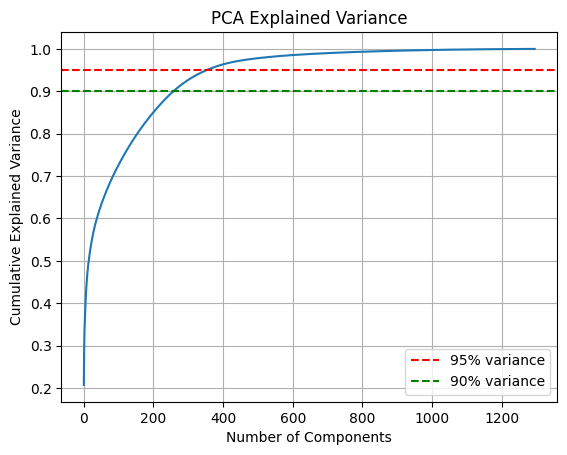

Number of components for 95% variance: 354
Number of components for 90% variance: 259


In [5]:
pca = PCA()
pca.fit(train_hog)

cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

plt.plot(cumulative_variance)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Explained Variance')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% variance')
plt.axhline(y=0.9, color='g', linestyle='--', label='90% variance')
plt.legend()
plt.grid()
plt.show()

n_components_95 = np.argmax(cumulative_variance >= 0.95) + 1
n_components_90 = np.argmax(cumulative_variance >= 0.9) + 1
print(f"Number of components for 95% variance: {n_components_95}")
print(f"Number of components for 90% variance: {n_components_90}")

# ~30s

In [6]:
n_components = n_components_95
pca = PCA(n_components=n_components)

train_pca = pca.fit_transform(train_hog)
test_pca = pca.transform(test_hog)

print(train_pca.shape, test_pca.shape)

# ~26s

(60000, 354) (10000, 354)


## Feature Visualization

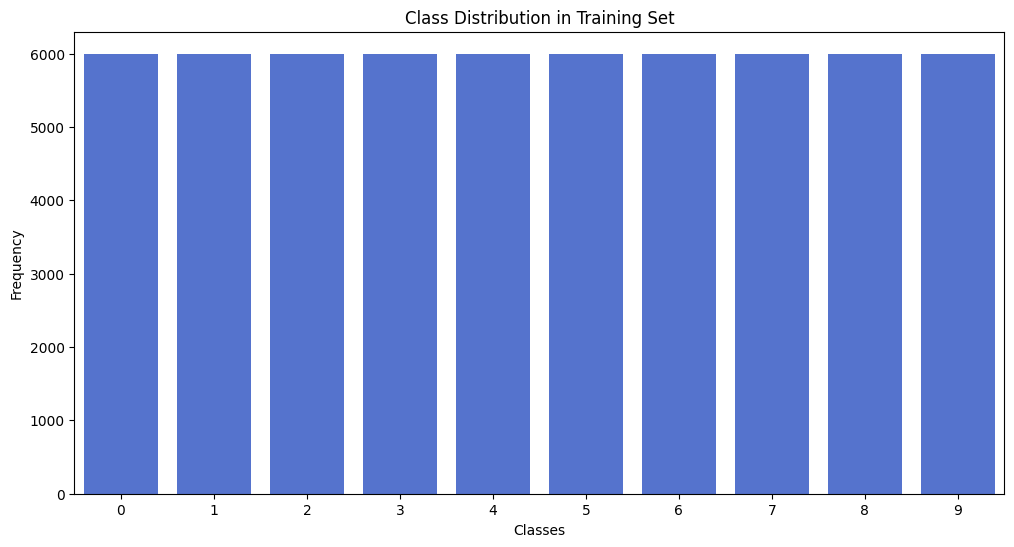

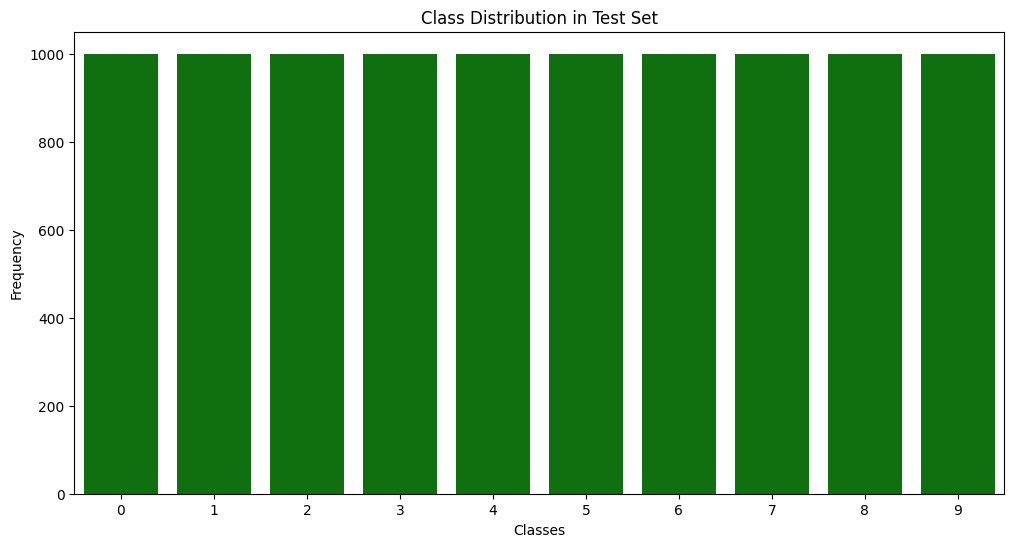

In [7]:
train_label_counts = np.bincount(train_labels)
test_label_counts = np.bincount(test_labels)

labels = np.arange(len(train_label_counts))

plt.figure(figsize=(12, 6))
sns.barplot(x=labels, y=train_label_counts, color="royalblue")
plt.xlabel("Classes")
plt.ylabel("Frequency")
plt.title("Class Distribution in Training Set")
plt.show()

plt.figure(figsize=(12, 6))
sns.barplot(x=labels, y=test_label_counts, color="green")
plt.xlabel("Classes")
plt.ylabel("Frequency")
plt.title("Class Distribution in Test Set")
plt.show()

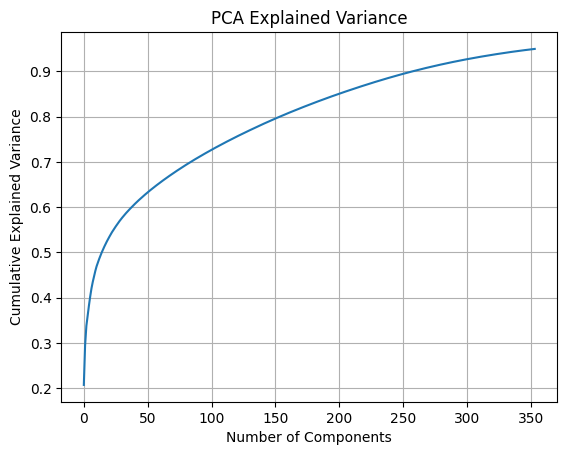

In [8]:
explained_variance = pca.explained_variance_ratio_
plt.plot(np.cumsum(explained_variance))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Explained Variance')
plt.grid()
plt.show()

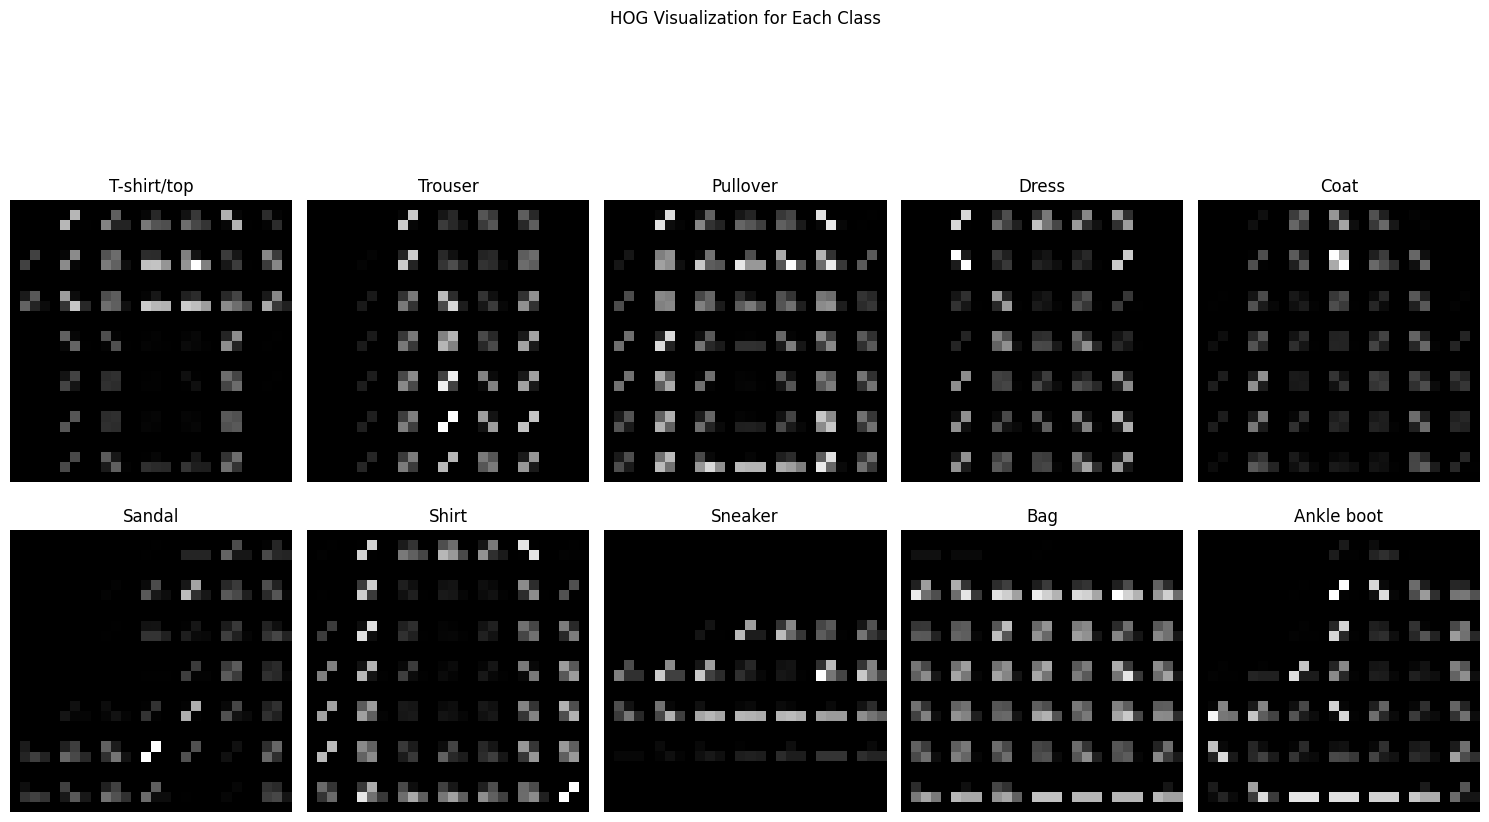

In [16]:
unique_classes = np.unique(train_labels)
plt.figure(figsize=(15, 10))

for i, label in enumerate(unique_classes):

    img_index = np.where(train_labels == label)[0][0]
    image = train_np[img_index]

    features, hog_image = hog(image, pixels_per_cell=(4, 4), cells_per_block=(1, 1), orientations=9, visualize=True)

    plt.subplot(2, 5, i + 1)
    plt.imshow(hog_image, cmap='gray')
    plt.title(f"{train_dataset.classes[label]}")
    plt.axis("off")
    plt.tight_layout()

plt.suptitle("HOG Visualization for Each Class")
plt.tight_layout()
plt.show()

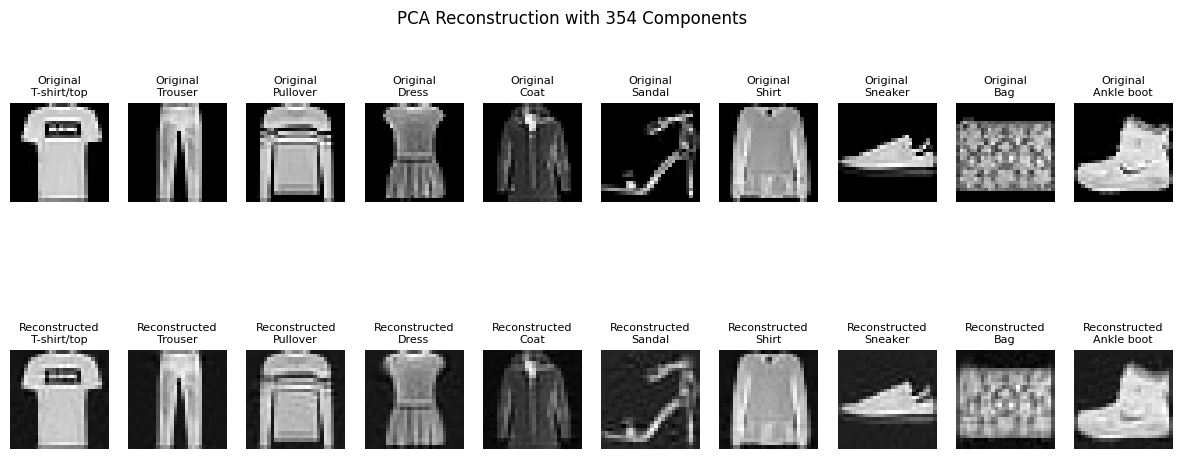

In [17]:
train_flat = train_np.reshape(train_np.shape[0], -1)
test_flat = test_np.reshape(test_np.shape[0], -1)

pca = PCA(n_components=n_components_95)
pca.fit(train_flat)

unique_classes = np.unique(train_labels)
plt.figure(figsize=(15, 5.5))

for i, label in enumerate(unique_classes):

    img_index = np.where(train_labels == label)[0][0]
    original_image = train_flat[img_index]

    reduced_features = pca.transform([original_image])
    reconstructed_image = pca.inverse_transform(reduced_features)

    plt.subplot(2, len(unique_classes), i + 1)
    plt.imshow(original_image.reshape(28, 28), cmap='gray')
    plt.title(f"Original\n{train_dataset.classes[label]}", fontsize=8)
    plt.axis("off")

    plt.subplot(2, len(unique_classes), len(unique_classes) + i + 1)
    plt.imshow(reconstructed_image.reshape(28, 28), cmap='gray')
    plt.title(f"Reconstructed\n{train_dataset.classes[label]}", fontsize=8)
    plt.axis("off")

plt.suptitle(f"PCA Reconstruction with {n_components} Components")
plt.subplots_adjust(wspace=0.2, hspace=0.4)
plt.show()

## Standardization and Feature Selection

In [18]:
scaler = StandardScaler()
train_pca_scaled = scaler.fit_transform(train_pca)
test_pca_scaled = scaler.transform(test_pca)

print(f"Shape before selection: {train_pca_scaled.shape}")

Shape before selection: (60000, 354)


In [19]:
threshold = 0.01
selector_variance = VarianceThreshold(threshold=threshold)
train_selected_variance = selector_variance.fit_transform(train_pca_scaled)
test_selected_variance = selector_variance.transform(test_pca_scaled)

print(f"Shape after Variance Threshold: {train_selected_variance.shape}")

Shape after Variance Threshold: (60000, 354)


In [20]:
percentile = 50
selector_percentile = SelectPercentile(score_func=f_classif, percentile=percentile)
train_selected_percentile = selector_percentile.fit_transform(train_selected_variance, train_labels)
test_selected_percentile = selector_percentile.transform(test_selected_variance)

print(f"Shape after Select Percentile: {train_selected_percentile.shape}")

Shape after Select Percentile: (60000, 177)


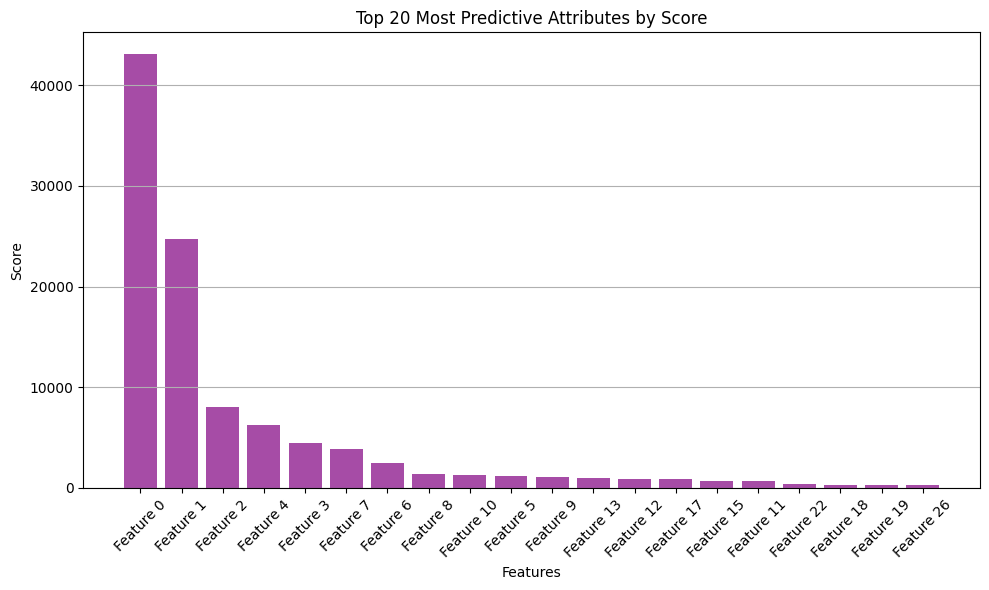

In [23]:
scores = selector_percentile.scores_
top_indices = np.argsort(scores)[::-1][:20]  # Indices of top 10 features

plt.figure(figsize=(10, 6))
plt.bar(range(20), scores[top_indices], color='purple', alpha=0.7)
plt.xticks(range(20), [f"Feature {i}" for i in top_indices], rotation=45)
plt.xlabel("Features")
plt.ylabel("Score")
plt.title("Top 20 Most Predictive Attributes by Score")
plt.grid(axis="y")
plt.tight_layout()
plt.show()

## Using Machine Learning Algoirthms for Predictions

In [21]:
X_train = train_selected_percentile
X_test = test_selected_percentile
y_train = train_labels
y_test = test_labels

In [26]:
def plot_confusion_matrix(model_name, y_true, y_pred, class_labels):
    cm = confusion_matrix(y_true, y_pred, labels=class_labels)

    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_dataset.classes, yticklabels=test_dataset.classes)
    plt.title(f'Confusion Matrix: {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

In [19]:
#param_grid_lr = {
#    "C": [0.001, 0.01, 0.1, 1, 10],
#    "solver": ["lbfgs"]
#}

#clf_lr = RandomizedSearchCV(LogisticRegression(max_iter=1000), param_grid_lr, cv=3, n_iter=5, n_jobs=-1)
#clf_lr.fit(X_train, y_train)

# Evaluare
#y_pred_lr = clf_lr.predict(X_test)
#print("Logistic Regression Best Params:", clf_lr.best_params_)
#print(classification_report(y_test, y_pred_lr))
#plot_confusion_matrix("Logistic Regression", y_test, y_pred_lr, class_labels=np.unique(y_test))


# ~11s
#Logistic Regression Best Params: {'solver': 'lbfgs', 'C': 0.01}

In [29]:
clf_lr = LogisticRegression(C=0.01, solver='lbfgs', max_iter=1000)
clf_lr.fit(X_train, y_train)

y_pred_lr = clf_lr.predict(X_test)

              precision    recall  f1-score   support

 T-shirt/top       0.82      0.84      0.83      1000
     Trouser       0.97      0.96      0.97      1000
    Pullover       0.81      0.78      0.80      1000
       Dress       0.87      0.86      0.87      1000
        Coat       0.78      0.81      0.79      1000
      Sandal       0.95      0.95      0.95      1000
       Shirt       0.65      0.63      0.64      1000
     Sneaker       0.92      0.95      0.93      1000
         Bag       0.96      0.97      0.97      1000
  Ankle boot       0.97      0.94      0.96      1000

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000



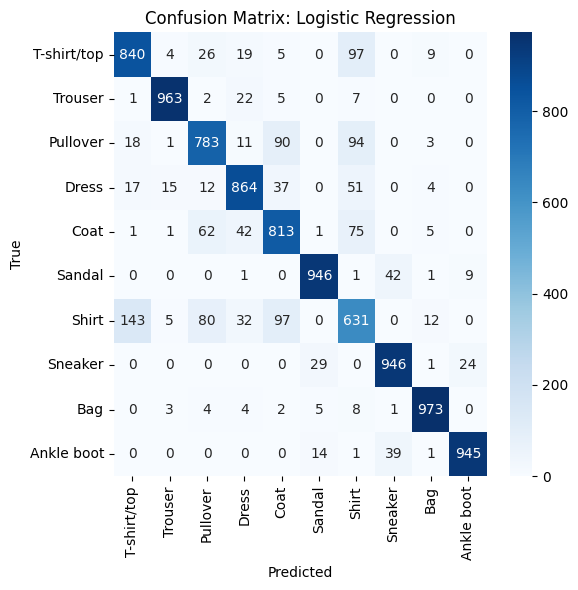

In [30]:
print(classification_report(y_test, y_pred_lr, target_names=test_dataset.classes))
plot_confusion_matrix("Logistic Regression", y_test, y_pred_lr, class_labels=unique_classes)

In [18]:
#param_grid_svm = {
#    "C": [0.1, 1],
#    "kernel": ["linear", "rbf"]
#}

#clf_svm = RandomizedSearchCV(SVC(), param_grid_svm, cv=3, n_iter=2, n_jobs=-1)
#clf_svm.fit(X_train, y_train)

#y_pred_svm = clf_svm.predict(X_test)
#print("SVM Best Params:", clf_svm.best_params_)
#print(classification_report(y_test, y_pred_svm))
#plot_confusion_matrix("SVM", y_test, y_pred_svm, class_labels=unique_classes)


# ~10m 37s
#SVM Best Params: {'kernel': 'rbf', 'C': 1}

              precision    recall  f1-score   support

           0       0.85      0.86      0.86      1000
           1       0.99      0.96      0.98      1000
           2       0.85      0.83      0.84      1000
           3       0.89      0.90      0.89      1000
           4       0.84      0.85      0.85      1000
           5       0.97      0.96      0.97      1000
           6       0.71      0.71      0.71      1000
           7       0.93      0.97      0.95      1000
           8       0.97      0.98      0.98      1000
           9       0.98      0.96      0.97      1000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



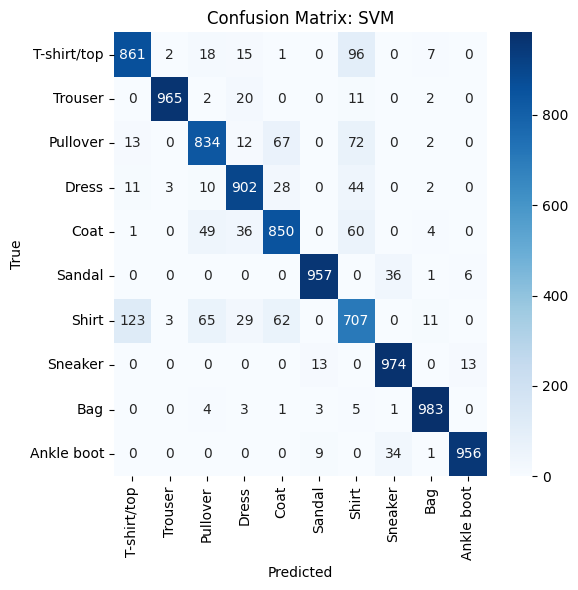

In [ ]:
clf_svm = SVC(C=1, kernel='rbf')
clf_svm.fit(X_train, y_train)

y_pred_svm = clf_svm.predict(X_test)

# ~4m 50s

              precision    recall  f1-score   support

 T-shirt/top       0.85      0.86      0.86      1000
     Trouser       0.99      0.96      0.98      1000
    Pullover       0.85      0.83      0.84      1000
       Dress       0.89      0.90      0.89      1000
        Coat       0.84      0.85      0.85      1000
      Sandal       0.97      0.96      0.97      1000
       Shirt       0.71      0.71      0.71      1000
     Sneaker       0.93      0.97      0.95      1000
         Bag       0.97      0.98      0.98      1000
  Ankle boot       0.98      0.96      0.97      1000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



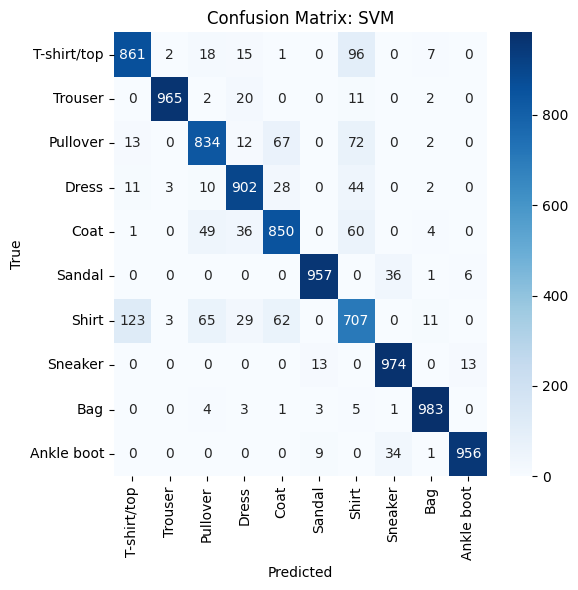

In [32]:
print(classification_report(y_test, y_pred_svm, target_names=test_dataset.classes))
plot_confusion_matrix("SVM", y_test, y_pred_svm, class_labels=unique_classes)

In [27]:
#param_grid_rf = {
#    "n_estimators": [100, 200],
#    "max_depth": [50, 60, 70],
#    "max_features": ["sqrt", "log2"]
#}

#clf_rf = RandomizedSearchCV(RandomForestClassifier(), param_grid_rf, cv=3, n_iter=3, n_jobs=-1)
#clf_rf.fit(X_train, y_train)

#y_pred_rf = clf_rf.predict(X_test)
#print("Random Forest Best Params:", clf_rf.best_params_)
#print(classification_report(y_test, y_pred_rf))
#plot_confusion_matrix("Random Forest", y_test, y_pred_rf, class_labels=unique_classes)

# ~11m 17s
#Random Forest Best Params: {'n_estimators': 200, 'max_features': 'sqrt', 'max_depth': 70}

In [ ]:
clf_rf = RandomForestClassifier(n_estimators=200, max_features='sqrt', max_depth=70)
clf_rf.fit(X_train, y_train)

y_pred_rf = clf_rf.predict(X_test)

# ~4m 50s

              precision    recall  f1-score   support

 T-shirt/top       0.81      0.85      0.83      1000
     Trouser       0.99      0.95      0.97      1000
    Pullover       0.81      0.79      0.80      1000
       Dress       0.85      0.89      0.87      1000
        Coat       0.78      0.82      0.80      1000
      Sandal       0.94      0.94      0.94      1000
       Shirt       0.68      0.60      0.64      1000
     Sneaker       0.91      0.93      0.92      1000
         Bag       0.94      0.97      0.95      1000
  Ankle boot       0.95      0.94      0.95      1000

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000



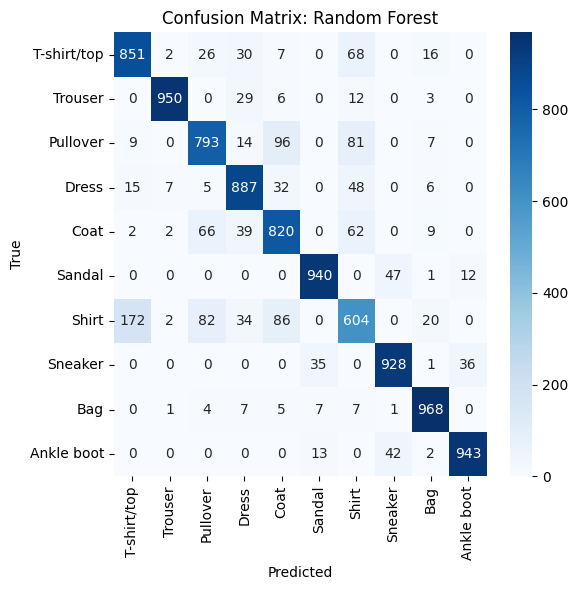

In [37]:
print(classification_report(y_test, y_pred_rf, target_names=test_dataset.classes))
plot_confusion_matrix("Random Forest", y_test, y_pred_rf, class_labels=unique_classes)

In [31]:
#param_grid_xgb = {
#    "n_estimators": [50, 100, 200],
#    "max_depth": [3, 6, 10],
#    "learning_rate": [0.01, 0.1, 0.2]
#}

#clf_xgb = RandomizedSearchCV(XGBClassifier(use_label_encoder=False, eval_metric="logloss"), param_grid_xgb, cv=3, n_iter=3, n_jobs=-1)
#clf_xgb.fit(X_train, y_train)

#y_pred_xgb = clf_xgb.predict(X_test)
#print("XGBoost Best Params:", clf_xgb.best_params_)
#print(classification_report(y_test, y_pred_xgb))
#plot_confusion_matrix("XGBoost", y_test, y_pred_xgb, class_labels=unique_classes)

# ~12m 43s
#XGBoost Best Params: {'n_estimators': 200, 'max_depth': 10, 'learning_rate': 0.01}

In [ ]:
clf_xgb = XGBClassifier(eval_metric="logloss", n_estimators=200, max_depth=10, learning_rate=0.01)
clf_xgb.fit(X_train, y_train)

y_pred_xgb = clf_xgb.predict(X_test)

# ~4m 25s

              precision    recall  f1-score   support

 T-shirt/top       0.83      0.83      0.83      1000
     Trouser       0.98      0.95      0.96      1000
    Pullover       0.79      0.79      0.79      1000
       Dress       0.86      0.86      0.86      1000
        Coat       0.75      0.79      0.77      1000
      Sandal       0.94      0.93      0.93      1000
       Shirt       0.65      0.63      0.64      1000
     Sneaker       0.90      0.94      0.92      1000
         Bag       0.95      0.95      0.95      1000
  Ankle boot       0.96      0.94      0.95      1000

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



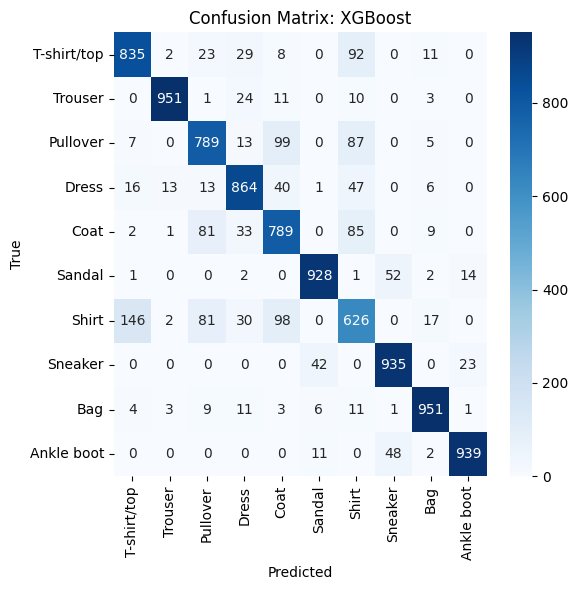

In [36]:
print(classification_report(y_test, y_pred_xgb, target_names=test_dataset.classes))
plot_confusion_matrix("XGBoost", y_test, y_pred_xgb, class_labels=unique_classes)